Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Tutorial #1: Train an image classification model with Azure Machine Learning

In this tutorial, you train a machine learning model on remote compute resources. You'll use the training and deployment workflow for Azure Machine Learning service (preview) in a Python Jupyter notebook.  You can then use the notebook as a template to train your own machine learning model with your own data. This tutorial is **part one of a two-part tutorial series**.  

This tutorial trains a simple logistic regression using the [MNIST](https://azure.microsoft.com/services/open-datasets/catalog/mnist/) dataset and [scikit-learn](http://scikit-learn.org) with Azure Machine Learning.  MNIST is a popular dataset consisting of 70,000 grayscale images. Each image is a handwritten digit of 28x28 pixels, representing a number from 0 to 9. The goal is to create a multi-class classifier to identify the digit a given image represents. 

Learn how to:

> * Set up your development environment
> * Access and examine the data
> * Train a simple logistic regression model on a remote cluster
> * Review training results, find and register the best model

You'll learn how to select a model and deploy it in [part two of this tutorial](deploy-models.ipynb) later. 

## Prerequisites

See prerequisites in the [Azure Machine Learning documentation](https://docs.microsoft.com/azure/machine-learning/service/tutorial-train-models-with-aml#prerequisites).

On the computer running this notebook, conda install matplotlib, numpy, scikit-learn=0.22.1

## Set up your development environment

All the setup for your development work can be accomplished in a Python notebook.  Setup includes:

* Importing Python packages
* Connecting to a workspace to enable communication between your local computer and remote resources
* Creating an experiment to track all your runs
* Creating a remote compute target to use for training

### Import packages

Import Python packages you need in this session. Also display the Azure Machine Learning SDK version.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.26.0


### Connect to workspace

Create a workspace object from the existing workspace. `Workspace.from_config()` reads the file **config.json** and loads the details into an object named `ws`.

In [2]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep='\t')

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


almabetter	eastus	azureml


### Create experiment

Create an experiment to track the runs in your workspace. A workspace can have muliple experiments. 

In [3]:
experiment_name = 'Tutorial-sklearn-mnist'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

### Create or Attach existing compute resource
By using Azure Machine Learning Compute, a managed service, data scientists can train machine learning models on clusters of Azure virtual machines. Examples include VMs with GPU support. In this tutorial, you create Azure Machine Learning Compute as your training environment. You will submit Python code to run on this VM later in the tutorial. 
The code below creates the compute clusters for you if they don't already exist in your workspace.

**Creation of compute takes approximately 5 minutes.** If the AmlCompute with that name is already in your workspace the code will skip the creation process.

In [4]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpu-cluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print("found compute target: " + compute_name)
else:
    print("creating new compute target...")
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes, 
                                                                max_nodes = compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

found compute target: cpu-cluster


You now have the necessary packages and compute resources to train a model in the cloud. 

## Explore data

Before you train a model, you need to understand the data that you are using to train it. In this section you learn how to:

* Download the MNIST dataset
* Display some sample images

### Download the MNIST dataset

Use Azure Open Datasets to get the raw MNIST data files. [Azure Open Datasets](https://docs.microsoft.com/azure/open-datasets/overview-what-are-open-datasets) are curated public datasets that you can use to add scenario-specific features to machine learning solutions for more accurate models. Each dataset has a corrseponding class, `MNIST` in this case, to retrieve the data in different ways.

This code retrieves the data as a `FileDataset` object, which is a subclass of `Dataset`. A `FileDataset` references single or multiple files of any format in your datastores or public urls. The class provides you with the ability to download or mount the files to your compute by creating a reference to the data source location. Additionally, you register the Dataset to your workspace for easy retrieval during training.

Follow the [how-to](https://aka.ms/azureml/howto/createdatasets) to learn more about Datasets and their usage in the SDK.

In [5]:
from azureml.core import Dataset
from azureml.opendatasets import MNIST

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

mnist_file_dataset = MNIST.get_file_dataset()
mnist_file_dataset.download(data_folder, overwrite=True)

mnist_file_dataset = mnist_file_dataset.register(workspace=ws,
                                                 name='mnist_opendataset',
                                                 description='training and test dataset',
                                                 create_new_version=True)

### Display some sample images

Load the compressed files into `numpy` arrays. Then use `matplotlib` to plot 30 random images from the dataset with their labels above them. Note this step requires a `load_data` function that's included in an `utils.py` file. This file is included in the sample folder. Please make sure it is placed in the same folder as this notebook. The `load_data` function simply parses the compresse files into numpy arrays.

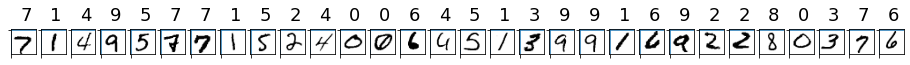

In [6]:
# make sure utils.py is in the same directory as this code
from utils import load_data
import glob


# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
X_train = load_data(glob.glob(os.path.join(data_folder,"**/train-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
X_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
y_train = load_data(glob.glob(os.path.join(data_folder,"**/train-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)
y_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)


# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

## Train on a remote cluster

For this task, you submit the job to run on the remote training cluster you set up earlier.  To submit a job you:
* Create a directory
* Create a training script
* Create a script run configuration
* Submit the job 

### Create a directory

Create a directory to deliver the necessary code from your computer to the remote resource.

In [7]:
import os
script_folder = os.path.join(os.getcwd(), "sklearn-mnist")
os.makedirs(script_folder, exist_ok=True)

### Create a training script

To submit the job to the cluster, first create a training script. Run the following code to create the training script called `train.py` in the directory you just created. 

In [8]:
%%writefile $script_folder/train.py

import argparse
import os
import numpy as np
import glob

from sklearn.linear_model import LogisticRegression
import joblib

from azureml.core import Run
from utils import load_data

# let user feed in 2 parameters, the dataset to mount or download, and the regularization rate of the logistic regression model
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--regularization', type=float, dest='reg', default=0.01, help='regularization rate')
args = parser.parse_args()

data_folder = args.data_folder
print('Data folder:', data_folder)

# load train and test set into numpy arrays
# note we scale the pixel intensity values to 0-1 (by dividing it with 255.0) so the model can converge faster.
X_train = load_data(glob.glob(os.path.join(data_folder, '**/train-images-idx3-ubyte.gz'), recursive=True)[0], False) / 255.0
X_test = load_data(glob.glob(os.path.join(data_folder, '**/t10k-images-idx3-ubyte.gz'), recursive=True)[0], False) / 255.0
y_train = load_data(glob.glob(os.path.join(data_folder, '**/train-labels-idx1-ubyte.gz'), recursive=True)[0], True).reshape(-1)
y_test = load_data(glob.glob(os.path.join(data_folder, '**/t10k-labels-idx1-ubyte.gz'), recursive=True)[0], True).reshape(-1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep = '\n')

# get hold of the current run
run = Run.get_context()

print('Train a logistic regression model with regularization rate of', args.reg)
clf = LogisticRegression(C=1.0/args.reg, solver="liblinear", multi_class="auto", random_state=42)
clf.fit(X_train, y_train)

print('Predict the test set')
y_hat = clf.predict(X_test)

# calculate accuracy on the prediction
acc = np.average(y_hat == y_test)
print('Accuracy is', acc)

run.log('regularization rate', np.float(args.reg))
run.log('accuracy', np.float(acc))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')

Writing C:\Users\lenovo\github\MachineLearningNotebooks\tutorials\image-classification-mnist-data\sklearn-mnist/train.py


Notice how the script gets data and saves models:

+ The training script reads an argument to find the directory containing the data.  When you submit the job later, you point to the dataset for this argument:
`parser.add_argument('--data-folder', type=str, dest='data_folder', help='data directory mounting point')`


+ The training script saves your model into a directory named outputs. <br/>
`joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')`<br/>
Anything written in this directory is automatically uploaded into your workspace. You'll access your model from this directory later in the tutorial.

The file `utils.py` is referenced from the training script to load the dataset correctly.  Copy this script into the script folder so that it can be accessed along with the training script on the remote resource.

In [9]:
import shutil
shutil.copy('utils.py', script_folder)

'C:\\Users\\lenovo\\github\\MachineLearningNotebooks\\tutorials\\image-classification-mnist-data\\sklearn-mnist\\utils.py'

### Configure the training job

Create a ScriptRunConfig object to specify the configuration details of your training job, including your training script, environment to use, and the compute target to run on. Configure the ScriptRunConfig by specifying:

* The directory that contains your scripts. All the files in this directory are uploaded into the cluster nodes for execution. 
* The compute target.  In this case you will use the AmlCompute you created
* The training script name, train.py
* An environment that contains the libraries needed to run the script
* Arguments required from the training script. 

In this tutorial, the target is AmlCompute. All files in the script folder are uploaded into the cluster nodes for execution. The data_folder is set to use the dataset.

First, create the environment that contains: the scikit-learn library, azureml-dataset-runtime required for accessing the dataset, and azureml-defaults which contains the dependencies for logging metrics. The azureml-defaults also contains the dependencies required for deploying the model as a web service later in the part 2 of the tutorial.

Once the environment is defined, register it with the Workspace to re-use it in part 2 of the tutorial.

In [10]:
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

# to install required packages
env = Environment('tutorial-env')
cd = CondaDependencies.create(pip_packages=['azureml-dataset-runtime[pandas,fuse]', 'azureml-defaults'], conda_packages = ['scikit-learn==0.22.1'])

env.python.conda_dependencies = cd

# Register environment to re-use later
env.register(workspace = ws)

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20210301.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "tutorial-env",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "anaconda",
                "conda-forge"

Then, create the ScriptRunConfig by specifying the training script, compute target and environment.

In [11]:
from azureml.core import ScriptRunConfig

args = ['--data-folder', mnist_file_dataset.as_mount(), '--regularization', 0.5]

src = ScriptRunConfig(source_directory=script_folder,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

### Submit the job to the cluster

Run the experiment by submitting the ScriptRunConfig object. And you can navigate to Azure portal to monitor the run.

In [13]:
run = exp.submit(config=src)
run

Experiment,Id,Type,Status,Details Page,Docs Page
Tutorial-sklearn-mnist,Tutorial-sklearn-mnist_1618153699_e815c4ea,azureml.scriptrun,Preparing,Link to Azure Machine Learning studio,Link to Documentation


Since the call is asynchronous, it returns a **Preparing** or **Running** state as soon as the job is started.

## Monitor a remote run

In total, the first run takes **approximately 10 minutes**. But for subsequent runs, as long as the dependencies in the Azure ML environment don't change, the same image is reused and hence the container start up time is much faster.

Here is what's happening while you wait:

- **Image creation**: A Docker image is created matching the Python environment specified by the Azure ML environment. The image is built and stored in the ACR (Azure Container Registry) associated with your workspace. Image creation and uploading takes **about 5 minutes**. 

  This stage happens once for each Python environment since the container is cached for subsequent runs.  During image creation, logs are streamed to the run history. You can monitor the image creation progress using these logs.

- **Scaling**: If the remote cluster requires more nodes to execute the run than currently available, additional nodes are added automatically. Scaling typically takes **about 5 minutes.**

- **Running**: In this stage, the necessary scripts and files are sent to the compute target, then data stores are mounted/copied, then the entry_script is run. While the job is running, stdout and the files in the ./logs directory are streamed to the run history. You can monitor the run's progress using these logs.

- **Post-Processing**: The ./outputs directory of the run is copied over to the run history in your workspace so you can access these results.


You can check the progress of a running job in multiple ways. This tutorial uses a Jupyter widget as well as a `wait_for_completion` method. 

### Jupyter widget

Watch the progress of the run with a Jupyter widget.  Like the run submission, the widget is asynchronous and provides live updates every 10-15 seconds until the job completes.

In [19]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

By the way, if you need to cancel a run, you can follow [these instructions](https://aka.ms/aml-docs-cancel-run).

### Get log results upon completion

Model training happens in the background. You can use `wait_for_completion` to block and wait until the model has completed training before running more code. 

In [15]:
# specify show_output to True for a verbose log
run.wait_for_completion(show_output=True) 

RunId: Tutorial-sklearn-mnist_1618153699_e815c4ea
Web View: https://ml.azure.com/runs/Tutorial-sklearn-mnist_1618153699_e815c4ea?wsid=/subscriptions/1feb5b4e-457d-4bbf-ba7e-8b46c8b29e43/resourcegroups/azureml/workspaces/almabetter&tid=600c68a9-2eea-4594-b7d6-6bd1e99ec760

Streaming azureml-logs/20_image_build_log.txt

2021/04/11 15:08:32 Downloading source code...
2021/04/11 15:08:33 Finished downloading source code
2021/04/11 15:08:34 Creating Docker network: acb_default_network, driver: 'bridge'
2021/04/11 15:08:34 Successfully set up Docker network: acb_default_network
2021/04/11 15:08:34 Setting up Docker configuration...
2021/04/11 15:08:35 Successfully set up Docker configuration
2021/04/11 15:08:35 Logging in to registry: almabettecrbo36dljlyybiw.azurecr.io
2021/04/11 15:08:36 Successfully logged into almabettecrbo36dljlyybiw.azurecr.io
2021/04/11 15:08:36 Executing step ID: acb_step_0. Timeout(sec): 5400, Working directory: '', Network: 'acb_default_network'
2021/04/11 15:08:36

Executing transaction: ...working... done
Installing pip dependencies: ...working... 
Ran pip subprocess with arguments:
['/azureml-envs/azureml_dd931c128d406a7bbcd016af032c59ce/bin/python', '-m', 'pip', 'install', '-U', '-r', '/azureml-environment-setup/condaenv.8fmgk2jl.requirements.txt']
Pip subprocess output:
  Created wheel for fusepy: filename=fusepy-3.0.1-py3-none-any.whl size=10504 sha256=692c3f8c6f477bc3fef70ea89f899bfa9d947ab2aa55ff4aadb720d63404640a
  Stored in directory: /root/.cache/pip/wheels/21/5c/83/1dd7e8a232d12227e5410120f4374b33adeb4037473105b079
  Created wheel for json-logging-py: filename=json_logging_py-0.2-py3-none-any.whl size=3924 sha256=06ef5dec17a35e2a2a48b8b0899058702291f1270c7a497cf567c67f934558a9
  Stored in directory: /root/.cache/pip/wheels/e2/1d/52/535a274b9c2ce7d4064838f2bdb62013801281ef7d7f21e2ee
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11730 sha256=ddbd5f3ddd24d50906a0e39d3954499d1f76bbba9d177c6cf46153b052b93a80


 ---> def0a44bebc4
Step 11/18 : COPY azureml-environment-setup/environment_context.json azureml-environment-setup/environment_context.json
 ---> 5acd8178d883
Step 12/18 : RUN python /azureml-environment-setup/send_conda_dependencies.py -p /azureml-envs/azureml_dd931c128d406a7bbcd016af032c59ce
 ---> Running in ec397d1cf3c9
Report materialized dependencies for the environment
Reading environment context
Exporting conda environment
Sending request with materialized conda environment details
Successfully sent materialized environment details
Removing intermediate container ec397d1cf3c9
 ---> b186a87aabd4
Step 13/18 : ENV AZUREML_CONDA_ENVIRONMENT_PATH /azureml-envs/azureml_dd931c128d406a7bbcd016af032c59ce
 ---> Running in e5c47863d060
Removing intermediate container e5c47863d060
 ---> f743280536ac
Step 14/18 : ENV LD_LIBRARY_PATH /azureml-envs/azureml_dd931c128d406a7bbcd016af032c59ce/lib:$LD_LIBRARY_PATH
 ---> Running in a5cd9e1ac109
Removing intermediate container a5cd9e1ac109
 ---> 56b60

Performing interactive authentication. Please follow the instructions on the terminal.


Note, we have launched a browser for you to login. For old experience with device code, use "az login --use-device-code"


You have logged in. Now let us find all the subscriptions to which you have access...
Interactive authentication successfully completed.

Streaming azureml-logs/75_job_post-tvmps_6bb880db65fe3b14a2fbad8c3811b541c892082b1632014f96515b8d9b67ceb9_d.txt

[2021-04-11T15:22:00.469466] Entering job release
[2021-04-11T15:22:01.931942] Starting job release
[2021-04-11T15:22:01.932606] Logging experiment finalizing status in history service.
Starting the daemon thread to refresh tokens in background for process with pid = 343
[2021-04-11T15:22:01.933183] job release stage : upload_datastore starting...
[2021-04-11T15:22:01.936304] job release stage : start importing azureml.history._tracking in run_history_release.
[2021-04-11T15:22:01.936830] job release stage : execute_job_release starting...
[2021-04-11T15:22:01.937202] job release stage : copy_batchai_cached_logs starting...
[2021-04-11T15:22:01.937430] job release stage : copy_batchai_cached_logs completed...
[2021-04-11T15:22:02.005251] E

{'runId': 'Tutorial-sklearn-mnist_1618153699_e815c4ea',
 'target': 'cpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2021-04-11T15:18:07.097609Z',
 'endTimeUtc': '2021-04-11T15:22:17.046962Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '36ff730e-4d5c-406c-9e72-66e3c8c17b70',
  'azureml.git.repository_uri': 'https://github.com/AlmaBetter-School/MachineLearningNotebooks.git',
  'mlflow.source.git.repoURL': 'https://github.com/AlmaBetter-School/MachineLearningNotebooks.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '6f893ff0b40d3d6af94ac43867676a3d9df1fcbd',
  'mlflow.source.git.commit': '6f893ff0b40d3d6af94ac43867676a3d9df1fcbd',
  'azureml.git.dirty': 'True',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': 'd18795bf-bf42-4762-a38b-1541cb1aed93'}, 'consumptionDetails': {'type': 'Run

### Display run results

You now have a model trained on a remote cluster.  Retrieve all the metrics logged during the run, including the accuracy of the model:

In [16]:
print(run.get_metrics())

{'regularization rate': 0.5, 'accuracy': 0.9193}


In the next tutorial you will explore this model in more detail.

## Register model

The last step in the training script wrote the file `outputs/sklearn_mnist_model.pkl` in a directory named `outputs` in the VM of the cluster where the job is executed. `outputs` is a special directory in that all content in this  directory is automatically uploaded to your workspace.  This content appears in the run record in the experiment under your workspace. Hence, the model file is now also available in your workspace.

You can see files associated with that run.

In [17]:
print(run.get_file_names())

['azureml-logs/20_image_build_log.txt', 'azureml-logs/55_azureml-execution-tvmps_6bb880db65fe3b14a2fbad8c3811b541c892082b1632014f96515b8d9b67ceb9_d.txt', 'azureml-logs/65_job_prep-tvmps_6bb880db65fe3b14a2fbad8c3811b541c892082b1632014f96515b8d9b67ceb9_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_6bb880db65fe3b14a2fbad8c3811b541c892082b1632014f96515b8d9b67ceb9_d.txt', 'azureml-logs/process_info.json', 'azureml-logs/process_status.json', 'logs/azureml/78_azureml.log', 'logs/azureml/dataprep/backgroundProcess.log', 'logs/azureml/dataprep/backgroundProcess_Telemetry.log', 'logs/azureml/job_prep_azureml.log', 'logs/azureml/job_release_azureml.log', 'logs/azureml/sidecar/tvmps_6bb880db65fe3b14a2fbad8c3811b541c892082b1632014f96515b8d9b67ceb9_d/all.log', 'logs/azureml/sidecar/tvmps_6bb880db65fe3b14a2fbad8c3811b541c892082b1632014f96515b8d9b67ceb9_d/task.enter_contexts.log', 'logs/azureml/sidecar/tvmps_6bb880db65fe3b14a2fbad8c3811b541c892082b1632014f96515b8d9b67ceb9_d

Register the model in the workspace so that you (or other collaborators) can later query, examine, and deploy this model.

In [18]:
# register model 
model = run.register_model(model_name='sklearn_mnist', model_path='outputs/sklearn_mnist_model.pkl')
print(model.name, model.id, model.version, sep='\t')

sklearn_mnist	sklearn_mnist:2	2


## Next steps

In this Azure Machine Learning tutorial, you used Python to:

> * Set up your development environment
> * Access and examine the data
> * Train multiple models on a remote cluster using the popular scikit-learn machine learning library
> * Review training details and register the best model

You are ready to deploy this registered model using the instructions in the next part of the tutorial series:

> [Tutorial 2 - Deploy models](img-classification-part2-deploy.ipynb)

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/tutorials/img-classification-part1-training.png)